# Drawing figures for the SIGIR paper

In [1]:
from sklearn.preprocessing import normalize

In [39]:
y2 = [1,9,1.5,0.9,0.8]
y1 = [1.1,1.7,1.2,1,0.8]

x1 = [1,2,3,4,5]
cols = ['r', 'r', 'g', 'r', 'r' ]

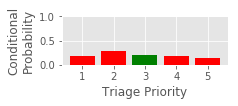

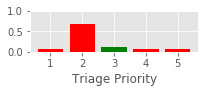

In [83]:
for i, (y, fname) in enumerate(zip([y1, y2], ['bad_prediction', 'worse_prediction'])):
    if i==0:
        plt.subplots(figsize=(3.5,1.5))
    else:
        plt.subplots(figsize=(3,1.4))
    np.array(y).reshape(1,-1)
    y = normalize(np.array(y).reshape(1,-1), norm='l1')
    ax = plt.bar(x1, y[0], color=cols)
    plt.xticks([1,2,3,4,5])
    plt.xlabel('Triage Priority')
    plt.ylim([0,1])
    if i==0:
        plt.ylabel('Conditional\nProbability')
    plt.tight_layout()
    plt.savefig(fname+'.pdf')
    plt.show()

In [84]:
y2 = [0,0,1,0,0]
y1 = [1.1,1.5,1.2,1,0.8]

x1 = [1,2,3,4,5]

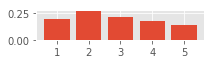

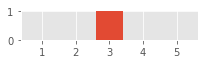

In [85]:
for y, fname in zip([y1, y2], ['bad_prediction', 'worse_prediction']):
    plt.subplots(figsize=(3,1))
    np.array(y).reshape(1,-1)
    y = normalize(np.array(y).reshape(1,-1), norm='l1')
    ax = plt.bar(x1, y[0])
    plt.xticks([1,2,3,4,5])
    plt.tight_layout()
    plt.show()

In [86]:
y = [1.1,1.5,1.2,0.8,0.4]

x1 = [1,2,3,4,5]
cols1 = ['r', 'r', 'g', 'r', 'r' ]
cols2 = ['r', 'r', 'r', 'r', 'g' ]

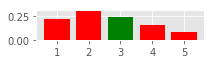

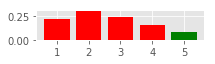

In [87]:
for cols, fname in zip([cols1, cols2], ['bad_prediction', 'worse_prediction']):
    plt.subplots(figsize=(3,1))
    np.array(y).reshape(1,-1)
    y = normalize(np.array(y).reshape(1,-1), norm='l1')
    ax = plt.bar(x1, y[0], color=cols)
    plt.xticks([1,2,3,4,5])
    plt.tight_layout()
    plt.savefig(fname+'.png')
    plt.show()

# Code for real

In [88]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
import re
import matplotlib.pyplot as plt

In [89]:
import EpDDM2

In [90]:
import sys
import os
tornado_path = os.path.abspath('../tornado')
sys.path.insert(0, tornado_path)

In [91]:
from data_structures.attribute_scheme import AttributeScheme
from classifier.__init__ import *
from drift_detection.__init__ import *
from filters.project_creator import Project
from graphic.hex_colors import Color
from streams.readers.arff_reader import ARFFReader
from tasks.prequential_learner_detector_pairs import PrequentialMultiPairs

In [92]:
plt.style.use('ggplot')

In [93]:
from importlib import reload
EpDDM2 = reload(EpDDM2)

In [94]:
CDDM = EpDDM2.EpDDM

In [95]:
def generate_data(n_samples, p, rate=0.5):
    # p = [ Pr(y=1|x=0), Pr(y=1|x=1) ]
    # rate is proportion of x=1 (rather than x=0)
    x = np.array([ np.random.choice(2, p=[1-rate, rate]) for i in range(n_samples) ])
    y = [ np.random.choice(2, p=[1-p[i], p[i]]) for i in x ]
    x = x.reshape(-1, 1)

    return x, y

class Experiment:
    
    pre_drift_n = 1000
    post_drift_n = 1000
    
    def __init__(self, probs, detector, model, rates, parameter=None):
        # probs = [a,b,c,d]
        # Before drift:
        # P(1|0) = a
        # P(1|1) = b
        # After drift:
        # P(1|0) = c
        # P(1|1) = d
        self.probs = probs
        self.detector = detector
        self.model = model
        self.result = None
        self.rates = rates
        self.parameter = parameter
        
    def run_experiment(self):
        x1, y1 = generate_data(Experiment.pre_drift_n, self.probs[:2], self.rates[0])
        x2, y2 = generate_data(Experiment.post_drift_n, self.probs[2:], self.rates[1])
        # return either none or the point of detection
        model = self.model
        if type(model)==str:
            model = eval(model)()
        detector = self.detector
        if type(detector)==str:
            detector = eval(detector)()
        monitor = []
        # Calibrate the detector
        for i in range(len(x1)):
            y_ = y1[i: i+1]
            x_ = x1[i: i+1]
            model.partial_fit(x_, y_, classes=[0,1])
            
            if type(detector)==EpDDM2.EpDDM:
                proba = model.predict_proba(x_)
                args = [proba, y_]
                try:
                    monitor.append(min(detector.hoeffding_bounds))
                except:
                    monitor.append(None)
            else:
                pred = model.predict([x_])
#                 print(pred, x_[0])
                pr = pred==y_
                args = [pr]
                monitor.append(pr)
                
            warning_status, drift_status = detector.detect(*args)
#         print(monitor)
#         print(detector.drift_threshold)
#         print('err rate', np.mean(np.array(prs).flatten()))
        monitor = []
        for i in range(len(x2)):
            y_ = y2[i: i+1]
            x_ = x2[i: i+1]
            
            if type(detector)==EpDDM2.EpDDM:
                proba = model.predict_proba(x_)
                args = [proba, y_]
                try:
                    monitor.append(min(detector.hoeffding_bounds))
                except:
                    monitor.append(None)
            else:
                pred = model.predict([x_])
#                 print(pred, /y_)
                pr = pred==y_
                args = [pr]
                monitor.append(pr)
                
            warning_status, drift_status = detector.detect(*args)
            
            if drift_status:
                self.result = i+1
#                 print('detected drift at', i)
                return i
#         print(monitor)
            
            # TODO: partial_fit model?
            
#            print(i, y_, x_, self.result)
        
        return
    
    def get_result_row(self):
        return pd.DataFrame({'Experiment': [f'{self.detector} + {self.model}'],
                            'Outcome': [self.result],
                           'Parameter': [self.parameter]})
    
class RepeatedExperiment:
    
    n_repeats = 1
    
    def __init__(self, probs, detector, model, rates):
        
        self.experiments = []
        self.detector = detector
        self.probs = probs
        self.model = model
        self.rates = rates
        
    def run_experiments(self):
#         print(self.detector, '\n\n')
        for i in range(RepeatedExperiment.n_repeats):
            new_experiment = Experiment(self.probs, self.detector, self.model, self.rates)
            new_experiment.run_experiment()
            self.experiments.append(new_experiment)
        
    def get_summary(self):
        results = [ exp.result for exp in self.experiments ]
        detections = [ i for i in results if i ]
        latency = np.mean(detections)
        try:
            recall = len(detections) / len(results)
        except:
            recall = 0
#         print(results)
        return {'latency': latency, 
                'detection_rate': recall }
    
class MultiDetectorExperiments:
    
    def __init__(self, probs, detectors, models, rates=[0.5, 0.5]):
        self.probs = probs
        self.detectors = detectors
        self.models = models
        self.repeated_experiments = {}
        self.rates = rates
        
    def run_experiments(self):
        for detector in self.detectors:
            for model in self.models:
                new_experiments = RepeatedExperiment(self.probs, eval(detector), eval(model), self.rates)
                new_experiments.run_experiments()
                name = f'{model} + {detector}'
                self.repeated_experiments[name] = new_experiments
        
    def results_table(self):
        table = pd.DataFrame(columns=['Experiment', 'Latency', 'Detection Rate'])
        i = 0
        for (name, repeated_experiment) in self.repeated_experiments.items():
            summary = repeated_experiment.get_summary()
            latency, detection_rate = summary['latency'], summary['detection_rate']
            table.loc[i] = [name, latency, detection_rate]
            
#             results = [ exp.result for exp in repeated_experiment.experiments ]
#             detections = [ i for i in results if i ]
#             print(detections)
#             latency = np.mean(detections)
            
            i += 1
        return table

In [96]:
class NB: # Naive Bayes
    def __init__(self):
        self.counts = { 0: np.array([1,1]), 1: np.array([1,1])}
    def partial_fit(self, x, y, classes=None):
        for x_, y_ in zip(x, y):
            self.counts[x_[0]][y_] += 1
        return self
    def predict_proba(self, x):
        ret = []
        for x_ in x:
#             x_ = x_[0]
            while not type(x_)==np.int64 and not type(x_)==int:
                x_ = x_[0]
            ret.append( self.counts[x_]/np.sum(self.counts[x_]) )
        ret = np.array(ret)
        return ret
    def predict(self, x):
        probs = self.predict_proba(x)
        ret = [ max([0,1], key=lambda x: line[x]) for line in probs ]
        return ret

In [97]:
detectors = ['CDDM', 'HDDM_A_test', 'RDDM']
models = ['NB']

def experiment(probs, rates, param=None, repeats=10):
    results = pd.DataFrame(columns=['Experiment', 'Parameter', 'Outcome'])
    for i in range(repeats):
        for detector in detectors:
            for model in models:
                exp = Experiment(probs, detector, model, rates, param)
                exp.run_experiment()
                results = results.append(exp.get_result_row())
    return results

# Detection Delay, High Confidence

In [121]:
def delay_experiment(epsilon):
    probs = [1-epsilon, epsilon, epsilon, 1-epsilon]
    rates = [0.5, 0.5]
    return experiment(probs, rates, param=epsilon, repeats=100)

def latency_experiments():
    results = pd.DataFrame(columns=['Experiment', 'Parameter', 'Outcome'])
    for epsilon in np.linspace(0, 0.3, num=20):
        results = results.append(delay_experiment(epsilon))
    return results

latency = latency_experiments()

In [122]:
# Tidy data so that seaborn will accept it
latency_ = latency[~(latency['Outcome'].isna())]
latency_['Outcome'] = latency_['Outcome'].astype('int')
latency_['Experiment'] = latency_['Experiment'].astype('category')

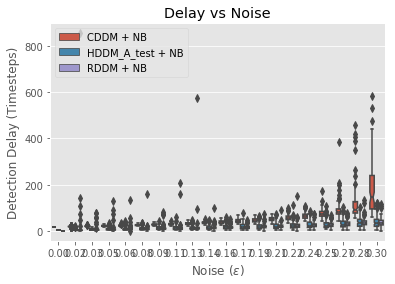

In [123]:
# Create plot
g = sns.boxplot(x='Parameter', y='Outcome', hue='Experiment', notch=True, data=latency_)
g.set(xlabel='Noise ($\epsilon$)', ylabel='Detection Delay (Timesteps)', title='Delay vs Noise');

# Fix the ticks
tick_labs = [ f'{float(i.get_text()):.2f}' for i in g.get_xticklabels()]#[::2] ]
g.set_xticklabels(tick_labs);
plt.legend(loc='upper left')
plt.savefig('delay_noise_plt.png');

Help on method legend in module matplotlib.axes._axes:

legend(*args, **kwargs) method of matplotlib.axes._subplots.AxesSubplot instance
    Place a legend on the axes.
    
    Call signatures::
    
        legend()
        legend(labels)
        legend(handles, labels)
    
    The call signatures correspond to three different ways how to use
    this method.
    
    **1. Automatic detection of elements to be shown in the legend**
    
    The elements to be added to the legend are automatically determined,
    when you do not pass in any extra arguments.
    
    In this case, the labels are taken from the artist. You can specify
    them either at artist creation or by calling the
    :meth:`~.Artist.set_label` method on the artist::
    
        line, = ax.plot([1, 2, 3], label='Inline label')
        ax.legend()
    
    or::
    
        line.set_label('Label via method')
        line, = ax.plot([1, 2, 3])
        ax.legend()
    
    Specific lines can be excluded from the au

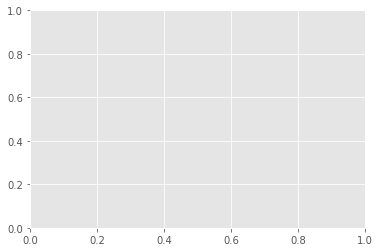

In [165]:
help(plt.gca().legend)

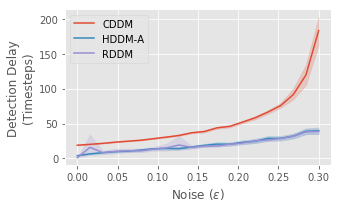

In [167]:
# Create plot
g = sns.relplot(x='Parameter', y='Outcome', hue='Experiment', kind='line', height=3, aspect=1, data=latency_)
g.set(xlabel='Noise ($\epsilon$)', ylabel='Detection Delay\n(Timesteps)')#, title='CDDM Detection Delay vs Noise');
plt.gca().legend(loc='upper left', labels=('CDDM', 'HDDM-A', 'RDDM'))
g._legend.remove()
plt.tight_layout()
plt.savefig('delay_noise_plt.pdf');

In [173]:
latency_.groupby('Experiment').mean()

,Outcome,Parameter
Experiment,,
CDDM + NB,51.953,0.15
HDDM_A_test + NB,19.279,0.15
RDDM + NB,19.422,0.15


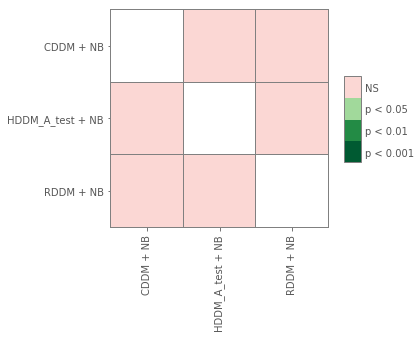

In [174]:
pc = sp.posthoc_nemenyi(latency_, val_col='Parameter', group_col='Experiment')
heatmap_args = {'linewidths': 0.25, 'linecolor': '0.5', 'clip_on': False, 'square': True, 'cbar_ax_bbox': [0.80, 0.35, 0.04, 0.3]}
sp.sign_plot(pc, **heatmap_args);

# False Positives vs Noise

In [104]:
def high_noise_experiment(epsilon):
    probs = [0.5-epsilon, 0.5+epsilon, 0.5-epsilon, 0.5+epsilon]
    rates = [0.5, 0.5]
    return experiment(probs, rates, param=epsilon, repeats=100)

def high_noise_experiments():
    results = pd.DataFrame(columns=['Experiment', 'Parameter', 'Outcome'])
    for epsilon in np.linspace(0, 0.5, num=10):
        results = results.append(high_noise_experiment(epsilon))
    return results

high_noise = high_noise_experiments()

In [105]:
post_drift_n = 1000

def get_fp_df(results):
    ret = results.copy()
    ret['Outcome'] = ret['Outcome'].apply(lambda x: 0 if x==None else 1/x)
    return ret

def get_fp_rate_df(results):
    experiments = list(results.Experiment.unique())
    fp_df = pd.DataFrame(columns=['Experiment', 'Parameter', 'Outcome'])
    i = 1
    for exp in results.Experiment.unique():
        for param in results.Parameter.unique():
            hn_i = results[(results.Experiment==exp) & (results.Parameter==param)]
            positives = [ i for i in hn_i.Outcome if i!=None]
            fp_df.loc[i, :] = [exp, param, len(positives)/len(hn_i)]
            i += 1
    fp_df['Experiment'] = fp_df['Experiment'].astype('category')
    fp_df['Parameter'] = fp_df['Parameter'].astype('float')
    fp_df['Outcome'] = fp_df['Outcome'].astype('float')
    return fp_df

In [106]:
high_noise_2 = get_fp_df(high_noise)

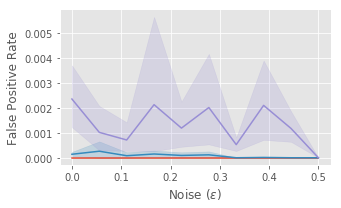

In [168]:
g = sns.relplot(x='Parameter', y='Outcome', hue='Experiment', kind='line', height=3, aspect=1, data=high_noise_2)#, legend=False)
g.set(xlabel='Noise ($\epsilon$)', ylabel='False Positive Rate')#, title='False Positives vs Noise Level');
# plt.gca().legend(loc='upper right')
g._legend.remove()
plt.tight_layout()
plt.savefig('noise_fp_plt.pdf');

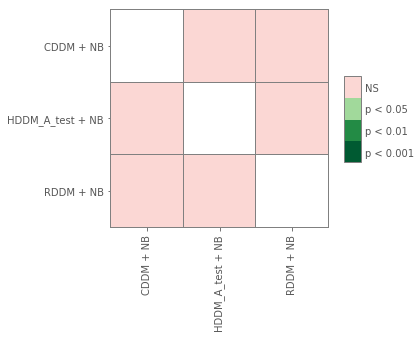

In [176]:
pc = sp.posthoc_nemenyi(high_noise_2, val_col='Parameter', group_col='Experiment')
heatmap_args = {'linewidths': 0.25, 'linecolor': '0.5', 'clip_on': False, 'square': True, 'cbar_ax_bbox': [0.80, 0.35, 0.04, 0.3]}
sp.sign_plot(pc, **heatmap_args);

# Virtual Drift False Positives

In [117]:
def vd_experiment(epsilon):
    probs = [1, 0.5, 1, 0.5]
    rates = [0.5-epsilon, 0.5+epsilon]
    return experiment(probs, rates, param=epsilon, repeats=100)

def vd_experiments():
    results = pd.DataFrame(columns=['Experiment', 'Parameter', 'Outcome'])
    for epsilon in np.linspace(0, 0.49, num=10):
        results = results.append(vd_experiment(epsilon))
    return results

vd_df2 = vd_experiments()

In [118]:
vd_fps2 = get_fp_df(vd_df2)

In [119]:
vd_fps2['Parameter'] = vd_fps2['Parameter'] * 2

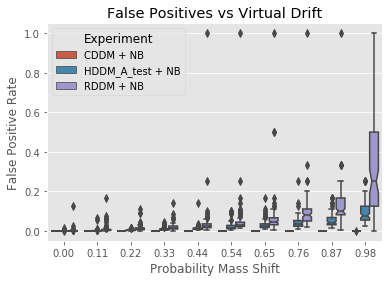

In [120]:
g = sns.boxplot(x='Parameter', y='Outcome', hue='Experiment', notch=True, data=vd_fps2)
g.set(xlabel='Probability Mass Shift', ylabel='False Positive Rate', title='False Positives vs Virtual Drift');

# Fix the ticks
tick_labs = [ f'{float(tick.get_text()):.2f}' for i, tick in enumerate(g.get_xticklabels())]#[::2] ]
g.set_xticklabels(tick_labs)
plt.savefig('virtual_drift_plt2.pdf');

# Virtual Drift False Positives v2

In [112]:
def vd_experiment(epsilon):
    probs = [0, 1-epsilon, 0, 1-epsilon]
    rates = [0.1, 0.9]
    return experiment(probs, rates, param=epsilon, repeats=100)

def vd_experiments():
    results = pd.DataFrame(columns=['Experiment', 'Parameter', 'Outcome'])
    for epsilon in np.linspace(0, 0.49, num=10):
        results = results.append(vd_experiment(epsilon))
    return results

vd_df = vd_experiments()

In [113]:
vd_fps = get_fp_df(vd_df)

In [114]:
vd_fps['Parameter'] = vd_fps['Parameter'] * 2

In [115]:
vd_fps['Parameter'] = vd_fps['Parameter'] / 2

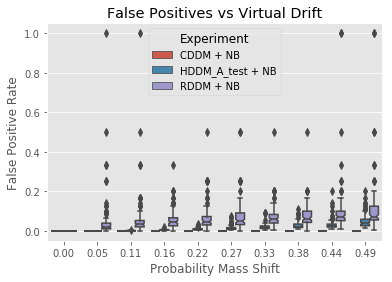

In [116]:
g = sns.boxplot(x='Parameter', y='Outcome', hue='Experiment', notch=True, data=vd_fps)
g.set(xlabel='Probability Mass Shift', ylabel='False Positive Rate', showfliers=False, title='False Positives vs Virtual Drift');

# Fix the ticks
tick_labs = [ f'{float(tick.get_text()):.2f}' for i, tick in enumerate(g.get_xticklabels())]#[::2] ]
g.set_xticklabels(tick_labs)
plt.savefig('virtual_drift_plt.pdf');

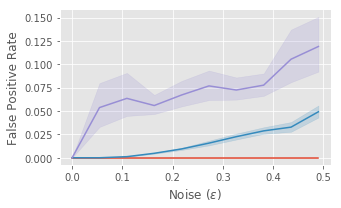

In [169]:
g = sns.relplot(x='Parameter', y='Outcome', hue='Experiment', kind='line', height=3, aspect=1, data=vd_fps)
g.set(xlabel='Noise ($\epsilon$)', ylabel='False Positive Rate')#, title='False Positives vs Virtual Drift');
g._legend.remove()
plt.tight_layout()
plt.savefig('virtual_drift_plt.pdf');

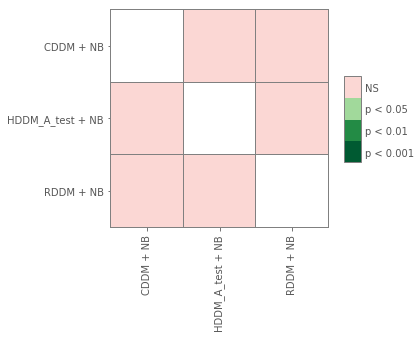

In [175]:
pc = sp.posthoc_nemenyi(vd_fps, val_col='Parameter', group_col='Experiment')
heatmap_args = {'linewidths': 0.25, 'linecolor': '0.5', 'clip_on': False, 'square': True, 'cbar_ax_bbox': [0.80, 0.35, 0.04, 0.3]}
sp.sign_plot(pc, **heatmap_args);

# Old Experiments

In [159]:
detectors = ['CDDM', 'HDDM_A_test', 'RDDM']
models = ['NaiveBayes2']
rates = [0.5, 0.5]

def high_noise_experiment(epsilon, repeats=10):
    probs = [0.5-epsilon, 0.5+epsilon, 0.5-epsilon, 0.5+epsilon]
    results = pd.DataFrame(columns=['Experiment', 'Parameter', 'Outcome'])
    for i in range(repeats):
        for detector in detectors:
            for model in models:
                exp = Experiment(probs, detector, model, rates, epsilon)
                exp.run_experiment()
                results = results.append(exp.get_result_row())
    return results

def high_noise_experiments(repeats=10):
    results = pd.DataFrame(columns=['Experiment', 'Parameter', 'Outcome'])
    for epsilon in np.linspace(0, 0.5, num=10):
        results = results.append(high_noise_experiment(epsilon, repeats))
    return results

high_noise = high_noise_experiments()

In [188]:
def get_fp_data(data):
    results = pd.DataFrame(columns=['Experiment', 'Parameter', 'Outcome'])
    i = 1
    for exp in data.Experiment.unique():
        for param in data.Parameter.unique():
            results_i = data[(data['Experiment']==exp) & (data['Parameter']==param)]
            if len(results_i)==0:
                continue
            detection_rate = len([i for i in results_i['Outcome'] if i])/len(results_i)
            results.loc[i, :] = [exp, param, detection_rate]
            i += 1
    return results

In [189]:
high_noise_fp = get_fp_data(high_noise)
high_noise_fp.head()

,Experiment,Parameter,Outcome
1,CDDM + NaiveBayes2,0,0
2,CDDM + NaiveBayes2,0.0555556,0
3,CDDM + NaiveBayes2,0.111111,0
4,CDDM + NaiveBayes2,0.166667,0
5,CDDM + NaiveBayes2,0.222222,0


In [368]:
# Detection latency for high confidence
probs = [0.9, 0.1, 0.1, 0.9]


detectors = ['CDDM', 'HDDM_A_test', 'RDDM', 'DDM']
models = ['SimpleModel']

exp = MultiDetectorExperiments(probs, detectors, models)

exp.run_experiments()
exp.results_table()

[30]
[17]
[9]
[1]


,Experiment,Latency,Detection Rate
0,SimpleModel + CDDM,30.0,1.0
1,SimpleModel + HDDM_A_test,17.0,1.0
2,SimpleModel + RDDM,9.0,1.0
3,SimpleModel + DDM,1.0,1.0


In [364]:
# False positives with high noise
probs = [0.55, 0.45, 0.55, 0.45]

detectors = ['EpDDM2.EpDDM', 'HDDM_A_test', 'RDDM', 'DDM']
models = ['SimpleModel']

exp = MultiDetectorExperiments(probs, detectors, models)

exp.run_experiments()
exp.results_table()

[None]
[None]
[470]
[None]


,Experiment,Latency,Detection Rate
0,SimpleModel + EpDDM2.EpDDM,NaN,0.0
1,SimpleModel + HDDM_A_test,NaN,0.0
2,SimpleModel + RDDM,470.0,1.0
3,SimpleModel + DDM,NaN,0.0


In [316]:
# virtual drift masking real drift
probs = [1, 0.5, 1, 0.5]
rates = [0.01, 0.99]

detectors = ['EpDDM2.EpDDM', 'HDDM_A_test', 'RDDM', 'DDM']
models = ['SimpleModel']

exp = MultiDetectorExperiments(probs, detectors, models, rates)

exp.run_experiments()
exp.results_table()

,Experiment,Latency,Detection Rate
0,SimpleModel + EpDDM2.EpDDM,NaN,0.0
1,SimpleModel + HDDM_A_test,15.5,1.0
2,SimpleModel + RDDM,48.0,0.9
3,SimpleModel + DDM,2.0,0.2


They have three common parameters: the confidence values
170 for drifts (αD =0.001) and warnings (αW =0.005), and the direction of the error, which can be one-sided (t=0, only
increments), default for HDDMW , or two-sided (t=1, error increments and decrements), and default for HDDMA.
Finally, HDDMW has an extra parameter (λ=0.05) that is used to control how much weight is given to more recent
data in comparison to older data.

In [639]:
import os

from streams.generators.__init__ import *

stream_names = ["sine", "circles", "mixed", "led"]
stream_objs = [SINE1, CIRCLES, MIXED, LEDConceptDrift]

for stream_name, sobj in zip(stream_names, stream_objs):
    for i in range(10):
        project_path = "data_streams2/_synthetic/" + stream_name + "/"
        if not os.path.exists(project_path):
            os.makedirs(project_path)

        file_path = project_path + stream_name + f'_{i}'

        stream_generator = sobj(concept_length=20000, random_seed=i)
        stream_generator.generate(file_path)

You are going to generate a SINE1 data stream containing 100000 instances, and 4 concept drifts; 
where they appear at every 20000 instances.
You can find the generated files in data_streams2/_synthetic/sine/sine_0.arff!
You are going to generate a SINE1 data stream containing 100000 instances, and 4 concept drifts; 
where they appear at every 20000 instances.
You can find the generated files in data_streams2/_synthetic/sine/sine_1.arff!
You are going to generate a SINE1 data stream containing 100000 instances, and 4 concept drifts; 
where they appear at every 20000 instances.
You can find the generated files in data_streams2/_synthetic/sine/sine_2.arff!
You are going to generate a SINE1 data stream containing 100000 instances, and 4 concept drifts; 
where they appear at every 20000 instances.
You can find the generated files in data_streams2/_synthetic/sine/sine_3.arff!
You are going to generate a SINE1 data stream containing 100000 instances, and 4 concept drifts; 
where they appear 

In [643]:
# Test
from data_structures.attribute_scheme import AttributeScheme
from classifier.__init__ import *
from drift_detection.__init__ import *
from filters.project_creator import Project
from graphic.hex_colors import Color
from streams.readers.arff_reader import ARFFReader
from tasks.prequential_learner_detector_pairs import PrequentialMultiPairs

def run_tornado_experiment(dataset_name):
    
    # for example, dataset_name='circles_0'
    
    # 1. Creating a project
    project = Project("experiments2", dataset_name)
    
    # 2. Loading an arff file
    dataset_type = dataset_name.rstrip('0123456789_')
    dataset_path = os.path.abspath(f'data_streams2/_synthetic/{dataset_type}/{dataset_name}.arff')
    labels, attributes, stream_records = ARFFReader.read(dataset_path)
    attributes_scheme = AttributeScheme.get_scheme(attributes)

    # 3. Initializing a Classifier-Detector Pairs
    pairs = [
             [NaiveBayes(labels, attributes_scheme['nominal']), CDDM()],
             [NaiveBayes(labels, attributes_scheme['nominal']), RDDM()],
             [NaiveBayes(labels, attributes_scheme['nominal']), HDDM_A_test()],
             [Perceptron(labels, attributes_scheme['numeric']), CDDM()],
             [Perceptron(labels, attributes_scheme['numeric']), RDDM()],
             [Perceptron(labels, attributes_scheme['numeric']), HDDM_A_test()]
            ]

    # 4. Creating a color set for plotting results
    colors = [Color.Indigo[1], Color.Blue[1], Color.Green[1], Color.Lime[1], Color.Yellow[1],
              Color.Amber[1], Color.Orange[1]][:len(pairs)]

    # 5. Defining actual locations of drifts, acceptance delay interval, and vector of weights
    actual_drift_points = [20000, 40000, 60000, 80000]
    drift_acceptance_interval = 250
    w_vec = [1, 1, 1, 1, 1, 1]

    # 6. Creating a Prequential Evaluation Process
    prequential = PrequentialMultiPairs(pairs, attributes, attributes_scheme,
                                        actual_drift_points, drift_acceptance_interval,
                                        w_vec, project, color_set=colors, legend_param=False)

    prequential.run(stream_records, 1)

In [42]:
from glob import glob

In [43]:
for i, path in enumerate(glob('./data_streams2/_synthetic/*/*.arff')):
    dataset_name = re.match(r'.*/([\w\d]+).arff', path).group(1)
    print(i, dataset_name)
    run_tornado_experiment(dataset_name)

0 led_2


NameError: name 'run_tornado_experiment' is not defined

In [46]:
def parse_results(path):
    path = os.path.abspath(path)
    dataset_name = re.match('^.*/(.*?).txt$', path).group(1)
    with open(path) as f:
        lines = f.read().split('\n')
    headers = lines[0].rstrip(']').lstrip('[')
    headers = [ header.lstrip() for header in headers.split(',') ]
    results = pd.DataFrame(columns=headers)
    i = 1
    for line in lines[1:]:
        fields = line.split('\t')
        if fields==['']:
            continue
        results.loc[i, :] = fields
        i += 1
        
    results['Dataset'] = dataset_name
        
    # Parse "Drift Detector Stats"
    total_delay = []
    tp = []
    location_of_last_detection = []
    fp, fn = [], []
    for i in range(len(results)):
        temp = eval(results.loc[i+1, 'Drift Detector Stats'])
        tdi, [lldi, tpi], fpi, fni = temp
        total_delay.append(tdi)
        tp.append(tpi)
        location_of_last_detection.append(lldi)
        fp.append(fpi)
        fn.append(fni)
    results['Total Delay'] = total_delay
    results['TP'] = tp
    results['FN'] = fn
    results['FP'] = fp
    
    # Split up name
    models = []
    detectors = []
    for i in range(len(results)):
        name = results.loc[i+1, 'Name']
        n_match = re.match('([\w\s]+) \+ ([\w\.]+)', name)
        models.append( n_match.group(1) )
        detectors.append( n_match.group(2) )
    results['Model'] = models
    results['Detector'] = detectors
    
    # Get wanted columns in right order
    results = results[['Dataset', 'Detector', 'Model', 'TP', 'FN', 'FP', 'Avg. Error-rate', 'Avg. Total Memory', 'Avg. Total Runtime', 'Total Delay']]
    results.columns = ['Dataset', 'Detector', 'Model', 'TP', 'FN', 'FP', 'Err-rate', 'Memory', 'Runtime', 'Total Delay']
        
    return results

In [79]:
results = pd.DataFrame(columns=['Dataset', 'Detector', 'Model', 'TP', 'FN', 'FP', 'Err-rate', 'Memory', 'Runtime', 'Total Delay'])

for i, path in enumerate(glob('./experiments2/*/*/*.txt')):
    results = results.append(parse_results(path))
results

,Dataset,Detector,Model,TP,FN,FP,Err-rate,Memory,Runtime,Total Delay
1,mixed_3,CDDM,NAIVE BAYES,4,0,0,0.0,45.77,13322.25,327
2,mixed_3,RDDM,NAIVE BAYES,4,0,0,14.56,103.1,377.44,404
3,mixed_3,HDDM.A.test,NAIVE BAYES,4,0,0,14.69,40.49,513.05,269
4,mixed_3,CDDM,PERCEPTRON,4,0,0,0.0,15.76,13134.9,273
5,mixed_3,RDDM,PERCEPTRON,4,0,0,18.3,73.1,259.19,474
6,mixed_3,HDDM.A.test,PERCEPTRON,4,0,1,18.360000000000003,10.49,382.53,250
1,mixed_4,CDDM,NAIVE BAYES,4,0,0,0.0,45.77,13294.3,339
2,mixed_4,RDDM,NAIVE BAYES,4,0,0,14.39,103.1,373.98,398
3,mixed_4,HDDM.A.test,NAIVE BAYES,4,0,0,14.48,40.49,513.61,225
4,mixed_4,CDDM,PERCEPTRON,4,0,0,0.0,15.75,13100.09,285


In [80]:
def get_the_data_table_ready_for_latex(results):
    
    latex_table = pd.DataFrame()
    
    ##########################################
    ###### Create the experiment column ######
    ##########################################
    
    def get_ds_name(str_):
        # get dataset name
        return re.match(r'([a-z]+).*', str_).group(1).upper()
    ds_names = results['Dataset'].apply(get_ds_name)
    
    det_names_map = {'HDDM.A.test': r'HDDM-A', 'CDDM': 'CDDM', 'RDDM': 'RDDM'}
    det_names = results['Detector'].map(det_names_map)
    
    model_names_map = {'NAIVE BAYES': 'NB', 'PERCEPTRON': 'PR'}
    model_names = results['Model'].map(model_names_map)
    
    exp_names = ds_names + '+' + det_names + '+' + model_names
    latex_table['Experiment'] = exp_names
    
    ##########################################
    ###### Precision and Recall         ######
    ##########################################
    
    # Calculate precision and recall
    tp = results['TP'].astype('float')
    fp = results['FP'].astype('float')
    fn = results['FN'].astype('float')
    prec = ( tp / (tp + fp) )
    prec = prec.map(lambda x: x if np.isfinite(x) else np.nan)
    rec = ( tp / (tp + fn) )
    latex_table['Prec'] = prec
    latex_table['Rec'] = rec

    # Copy over other metrics
    for i in ['Memory', 'Runtime', 'Total Delay']:
        latex_table[i] = results[i].astype('float')
        
    ##########################################
    ###### Mean and Standard Deviation  ######
    ##########################################
    
    means_table = pd.DataFrame(columns=latex_table.columns, 
                               index=latex_table['Experiment'].unique())
    for exp in latex_table['Experiment'].unique():
        this_exp = latex_table[ latex_table['Experiment']==exp ]
        
        for col in means_table.columns:
            
            if col=='Experiment':
                means_table.loc[exp, col] = exp
                continue
            
            col_vals = this_exp[col]
            
            mean = np.nanmean(col_vals)
            std = np.nanstd(col_vals)
            
#             if std==0:
#                 display(this_exp)
            
            entry = f'{mean:.2f} ({std:.2f})' if not np.isnan(mean) else '- (-)'
            means_table.loc[exp, col] = entry
        
    ##########################################
    ###### Print LaTeX and return table ######
    ##########################################
        
    print( means_table.to_latex(index=False) )
    
    return latex_table, means_table

In [81]:
latex_table, means_table = get_the_data_table_ready_for_latex(results);

\begin{tabular}{llllll}
\toprule
        Experiment &         Prec &          Rec &         Memory &              Runtime &     Total Delay \\
\midrule
     MIXED+CDDM+NB &  1.00 (0.00) &  1.00 (0.00) &   45.77 (0.00) &     13327.96 (72.02) &  347.30 (17.56) \\
     MIXED+RDDM+NB &  0.97 (0.10) &  1.00 (0.00) &  103.10 (0.01) &        379.64 (4.18) &  396.60 (16.38) \\
   MIXED+HDDM-A+NB &  1.00 (0.00) &  1.00 (0.00) &   40.49 (0.00) &        515.29 (2.51) &  271.40 (47.03) \\
     MIXED+CDDM+PR &  1.00 (0.00) &  1.00 (0.00) &   15.76 (0.01) &    13234.50 (163.42) &  292.50 (24.52) \\
     MIXED+RDDM+PR &  0.91 (0.12) &  1.00 (0.00) &   73.10 (0.00) &       252.06 (14.05) &  486.00 (67.28) \\
   MIXED+HDDM-A+PR &  0.91 (0.12) &  1.00 (0.00) &   10.49 (0.00) &       383.95 (11.66) &  350.30 (71.65) \\
      SINE+CDDM+NB &  1.00 (0.00) &  1.00 (0.00) &   39.02 (0.00) &    13285.65 (134.14) &  342.70 (29.05) \\
      SINE+RDDM+NB &  0.98 (0.06) &  1.00 (0.00) &   96.34 (0.00) &        324

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:58: RuntimeWarning: Mean of empty slice


In [182]:
print( means_table.drop(columns=['Memory', 'Experiment']).to_latex() )

\begin{tabular}{lllll}
\toprule
{} &         Prec &          Rec &              Runtime &     Total Delay \\
\midrule
MIXED+CDDM+NB     &  1.00 (0.00) &  1.00 (0.00) &     13327.96 (72.02) &  347.30 (17.56) \\
MIXED+RDDM+NB     &  0.97 (0.10) &  1.00 (0.00) &        379.64 (4.18) &  396.60 (16.38) \\
MIXED+HDDM-A+NB   &  1.00 (0.00) &  1.00 (0.00) &        515.29 (2.51) &  271.40 (47.03) \\
MIXED+CDDM+PR     &  1.00 (0.00) &  1.00 (0.00) &    13234.50 (163.42) &  292.50 (24.52) \\
MIXED+RDDM+PR     &  0.91 (0.12) &  1.00 (0.00) &       252.06 (14.05) &  486.00 (67.28) \\
MIXED+HDDM-A+PR   &  0.91 (0.12) &  1.00 (0.00) &       383.95 (11.66) &  350.30 (71.65) \\
SINE+CDDM+NB      &  1.00 (0.00) &  1.00 (0.00) &    13285.65 (134.14) &  342.70 (29.05) \\
SINE+RDDM+NB      &  0.98 (0.06) &  1.00 (0.00) &        324.30 (3.24) &  410.70 (28.59) \\
SINE+HDDM-A+NB    &  0.87 (0.17) &  1.00 (0.00) &       440.97 (30.92) &  278.10 (30.47) \\
SINE+CDDM+PR      &  1.00 (0.00) &  1.00 (0.00) &     

# Post-hoc Tests

In [65]:
tornado_path = os.path.abspath('../scikit-posthocs')
sys.path.insert(0, tornado_path)
import scikit_posthocs as sp
import statsmodels.formula.api as sfa
import statsmodels.api as sa

In [67]:
from IPython.display import display, Markdown

In [68]:
results = latex_table
results['Detector'] = results['Experiment'].apply(lambda x: 'RDDM' if 'RDDM' in x else 'CDDM' if 'CDDM' in x else 'HDDM-A')

In [74]:
means_table = results.copy()
means_table.groupby('Detector').mean()

,Prec,Rec,Memory,Runtime,Total Delay
Detector,,,,,
CDDM,0.759259,0.504167,52.702125,30956.36575,530.4125
HDDM-A,0.662932,0.737500,47.548125,1021.42800,454.8125
RDDM,0.578333,0.608333,110.169750,910.03250,571.4250


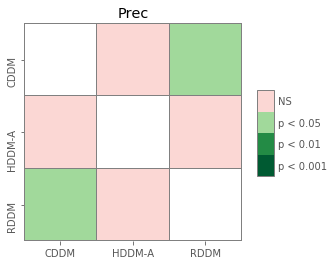

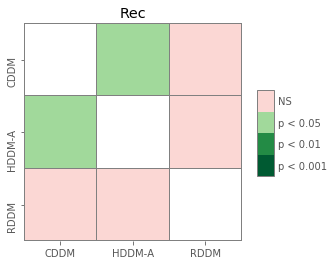

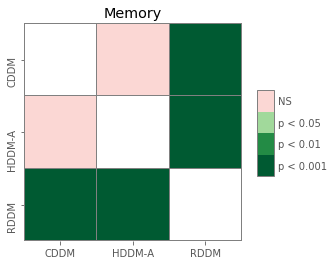

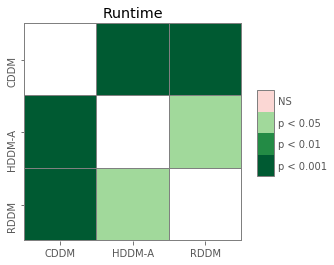

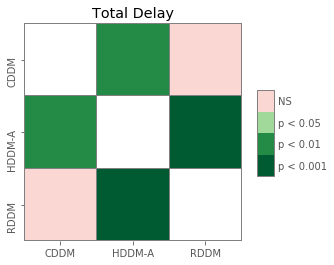

In [69]:
for col in results.columns[1:-1]:
    plt.figure()
#     display(Markdown('## '+col))
    pc = sp.posthoc_nemenyi(results, val_col=col, group_col='Detector')
    heatmap_args = {'linewidths': 0.25, 'linecolor': '0.5', 'clip_on': False, 'square': True, 'cbar_ax_bbox': [0.80, 0.35, 0.04, 0.3]}
    plt.title(col)
    sp.sign_plot(pc, **heatmap_args);

In [75]:
pc

,CDDM,HDDM-A,RDDM
CDDM,-1.000000,0.006247,0.339721
HDDM-A,0.006247,-1.000000,0.000020
RDDM,0.339721,0.000020,-1.000000


In [ ]:
def p_to_sign(p):
    